# 1.3  -- Creating Customer Profiles

DunnHumby The Complete Journey

Nathaniel Poland

## Data Pipeline Package
In order to simplify or manage the workflow of a data product, we can employ a package of scripts, or functions.  

Working in a Jupyter Notebook feels like a much safer place to experiment with data pipelining for me right now; but as far as I understand, bash and SQL will be primary tools in constructing data pipelines in industry. The process thus far has been an educational one for me and helped to solidify my foundation with my primary (first, and only) scripting language, Python, while working my way through some basic comprehension of this critical data infrastructure piece.

Obviously, we want to be able to load the relevant data (without any null values, only of the relevant type, etc.) -- and hopefully not spend too much unnecessary computing power or memory to do so, especially on pay-as-you-go cloud software. I know I still have a ton to learn about what that might look like for any given organization; I'm confident that I will learn quickly on the job. Just like when you're making bread, every kitchen is different. Things that work in one environment may not work well in another.

We might employ a 'Unit Test'; to check that our data is exactly what we expect it to be. I still have a lot to learn about what this might look like in any given data workflow, but since I'm the only person working on this project and everything is hosted locally, I am bypassing this (extremely important) step with caution and humility. I hope that this limited exposure to project API development will further my comprehension of workflows and systems in future workplaces. 

Using the package for this project (labeled dtcj, for dunnhumby the complete journey), I load the cleaned version of our data below.

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize']==(6,6)

import dtcj


In [2]:
# load data
merged = dtcj.load_merged()


## Continuing on...


Now that we have transactions with appropriate products labels, we can also begin the process of distinguishing our households into meaningful groups. I'm banking on the idea that there is some sort of relationship between the attributes of each household (which we are about to define), and the products that they purchase (what we hope to predict).

If this proves to be the case, we can make more intelligent and cost-effective recommendations for our households. By examining the association rules for different market segments, we can determine the most effective strategy for product placement and direct marketing.

# Developing Customer Profiles



## RFM Score

In this case, I'll start by ranking households using RFM score -- the Recency, Frequency, and Monetary value of their transactions.

We rank each household on a scale of 1-5, with 5 being the most 'valuable' households in each of the Recency, Frequency, and Monetary domains.

By using pandas .qcut(), we can easily create even-sized quantile bins.

### Recency

We should take note that our sample group are 'frequent purchasers'; so this metric could be misleading in terms of pushing a model or pipeline onto live or new data -- we would have to develop a different means of defining recency in that case.

Instead of using .qcut(), I will assign a score of 5 to any household which made a purchase within the last two weeks of the data. 

In [3]:
# find the last day of purchase for each household
last_days = merged.groupby('household_key')['DAY'].max()
last_days.head()


household_key
1    706
2    668
3    703
4    627
5    703
Name: DAY, dtype: int64

#### Plotting Original Recency Distribution

In [4]:
print(merged['DAY'].min(),merged['DAY'].max())
# we have 608 days of data

101 708


We have 608 days of data left after truncations. We know our households are supposed to be 'frequent' shoppers at our stores. How recently did each one purchase?

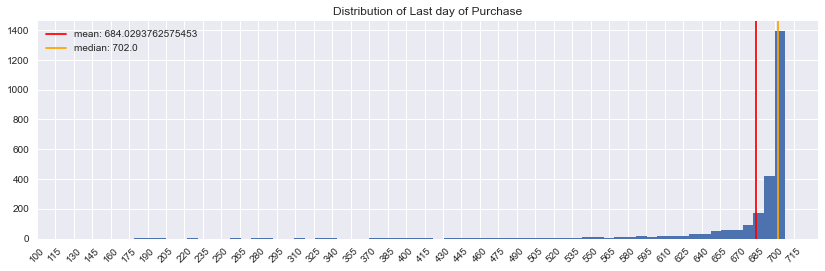

In [10]:
# plot the range 101 to 708+
plt.figure(figsize=(14,4))
plt.title('Distribution of Last day of Purchase')
last_days.hist(bins=61)
plt.xticks(range(100,730,15), rotation=45)
plt.axvline(last_days.mean(), color='red', label=f'mean: {last_days.mean()}')
plt.axvline(last_days.median(), color='orange', label=f'median: {last_days.median()}')
plt.legend()
plt.show()
# 

In [9]:
print(last_days.mean())
print(last_days.describe())



684.0293762575453
count    2485.000000
mean      684.029376
std        52.095327
min       179.000000
25%       688.000000
50%       702.000000
75%       706.000000
max       708.000000
Name: DAY, dtype: float64


In [10]:
# NOTE: It looks like the data is pretty solid through the end of the date range

## last_days.describe()

This is clearly not a normal distribution. But before we panic, let's think about what the data is telling us. In this case, we have a lot of hits at the top end of the spectrum; right up close to the last days in the data. We see that **50% of the households actually had a last purchase within the past week, divided at day 702**. 

Since we're considering sorting using the pd.qcut() method (which creates even class distributions for our scores by separating the column by quantiles), we might be placing certain households with fairly similar recency of purchase into different categories.

It would make more sense to me if we classified all households who purchased in the past week or so as very-high frequency shoppers.  This issue is more so a problem with the methodology of RFM score in this instance; but we shouldn't corrupt our data simply to make things appear "normal" on the graph -- the underlying phenomena is what we seek to describe -- in an interpretable, accurate, and relevant way. 

Let's compare the two options visually, and then I'll describe the meaning of boundaries I would use.

#### Plotting Distributions for alternative Recency Score Calculations

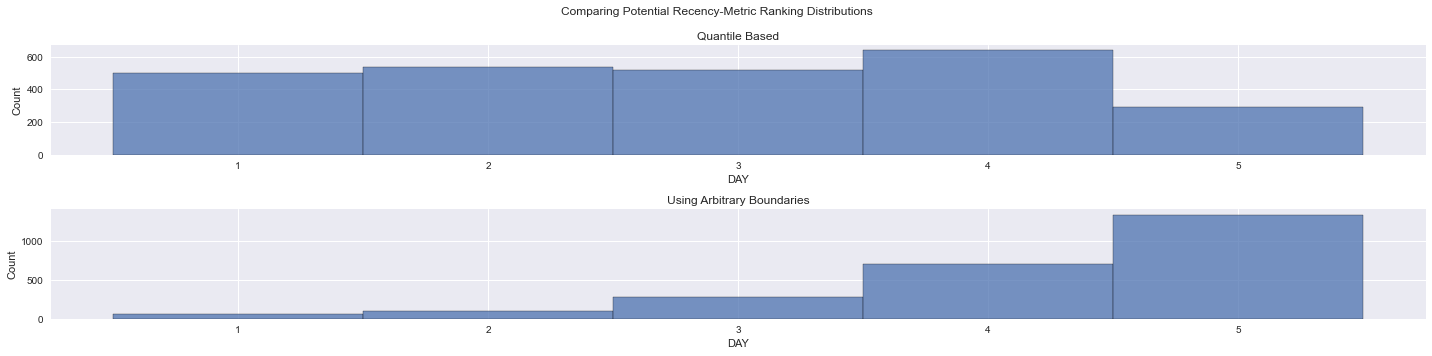

In [11]:
plt.subplots(2,1,figsize=(20,5))
plt.suptitle('Comparing Potential Recency-Metric Ranking Distributions')

plt.subplot(2,1,1)
plt.title('Quantile Based')
# ALTERNATIVE ONE; USE THE QUANTILES
R = pd.qcut(last_days, 5, labels=[1,2,3,4,5])
sns.histplot(R)

plt.ticks = range(1,5)
plt.subplot(2,1,2)
# ALTERNATIVE TWO; USE BUSINESS-LANGUAGE DECISION BOUNDARIES
plt.title('Using Arbitrary Boundaries')
## within 1 year; within 3 months; within one month; within 1 weeks...
R = pd.cut(last_days, [0, 525, 615, 675, 700, np.inf], labels=[1,2,3,4,5], ordered=True)
sns.histplot(R)

plt.tight_layout()
plt.show()

In the first plot, since our distribution is so dense near the end, we have boundary conflicts on the discrete DAY axis! 

This results in improper binning; moreover, we have a significant number of households classified with the lowest possible score. This does not correlate with the real underlying phenomena. We could employ a transformation to reduce the boundary conflict, but I have opted with the second strategy because I believe they better represent business-facing values as the relevant R Score metric. They represent customers who purchased:

- more than 183 days ago; (more than 6 months ago)
- within the past 183 days; (in the past 6 months)
- in the past 93 days;  (in the past 3 months)
- the past 33 days;  (in the past month)
- and the past 8 days, (in the past week)

respectively. 

Basically I'm saying that if they've made a purchase **within the past week**, they should be a high-frequency customer, for sure! They're coming into our stores **very often**. Unfortunately (Fortunately!) for us as data scientists, that actually accounts for half of our data; a very high participation/frequency is displayed by this sample group. 


We have to move the boundary out to one month to pick up another quarter of the households, and to get almost half of that, we have to move to three months. 

If we bin this way we can explain our group labels much more easily to stakeholders. 


However, it bears re-iterating that **we don't know if this is representative of the behaviour of the underlying population**. In fact, based on the nature of the experiment, we're pretty sure it's not. The distribution of these scores is an artifact of our sampling method, but accurately represents the data we have. 

### Frequency

Just like Recency, the frequency of purchase for our customers is likely to be high.

We should have data which represents all the transactions by our distinct households over this same timeframe -- so there's an argument to be made to use number of baskets outright. 

However, this method of binning would punish customers who have come on over the course of the data, and are now become steady and frequent shoppers.

This is easily a debatable approach, as we are supposed to have consistent information from all 2500 households over the data.

In [12]:
num_baskets = merged.groupby('household_key')['BASKET_ID'].nunique()

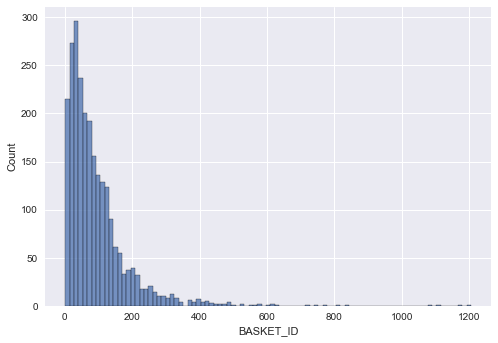

In [13]:
sns.histplot(num_baskets); # first pass

Another method of developing this rank (although it introduces a different kind of bias) would be to count the number of days each household is in the data, and divide by the number of baskets they purchased to find their purchases per day. 

#### Potential Errors...

For any customers who randomly made several purchases but did not become frequent shoppers, this method may be misleading; for customers who didn't purchase for a long stretch of time bounding on the beginning or the end of our dataset it might be misleading.

The impacts of these errors should be somewhat accounted for by using the quantile separation of total spend for monetary scores, below.

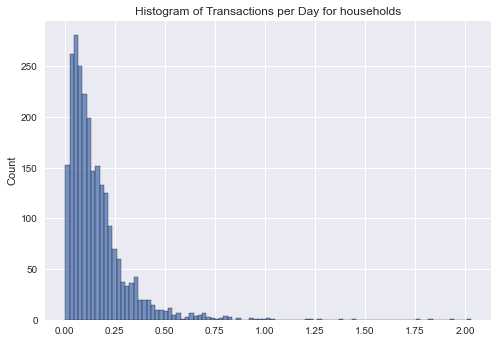

In [14]:
#take each household's day column
grouper = merged.groupby('household_key')['DAY']
# find their duration in transactions table
days_in_data = grouper.max() - grouper.min() + 1 #(no day 0 in our data)
# find their baskets per day value
transactions_per_day = num_baskets/days_in_data
sns.histplot(transactions_per_day)
plt.title('Histogram of Transactions per Day for households');

This looks a lot like our original data -- I think that's a good thing? We can now apply a quantile separation to create an even class distribution for our Frequency metric.

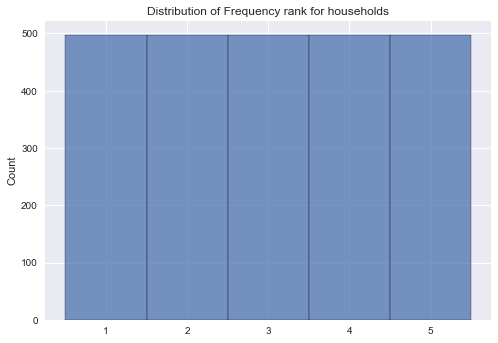

In [15]:
F = pd.qcut(transactions_per_day, 5, labels=[1,2,3,4,5])
sns.histplot(F)
plt.title('Distribution of Frequency rank for households');

### Monetary

Finally, we should identify the Monetary rank for each household. Since we have other ranks for frequency and recency of purchase, this should probably just be some distribution of the total sales value.

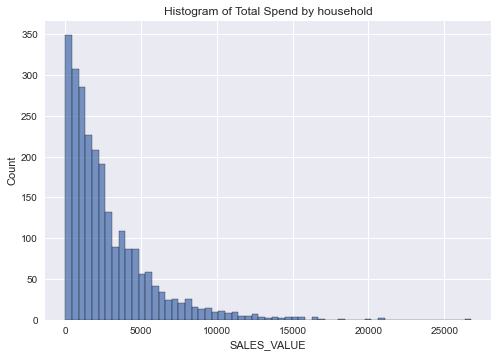

In [16]:
sns.histplot(merged.groupby('household_key')['SALES_VALUE'].sum())
plt.title('Histogram of Total Spend by household');

To prevent any boundary conflicts etc., I'm going to log transform the sum of sales first. This doesn't seem necessary because .qcut() is percentile based, but I don't think it will hurt, either. 

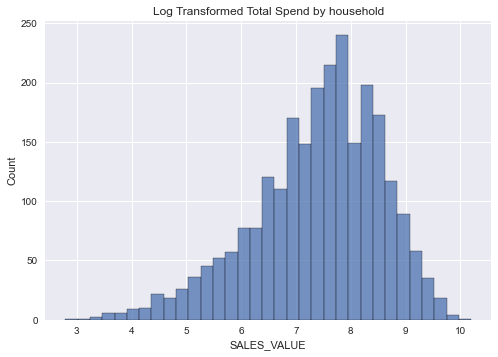

In [17]:
sns.histplot(np.log(merged.groupby('household_key')['SALES_VALUE'].sum()))
plt.title('Log Transformed Total Spend by household');

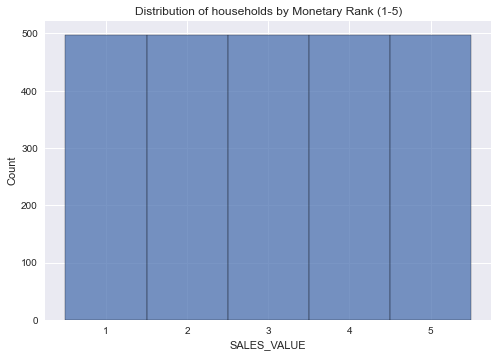

In [18]:
M = pd.qcut(np.log(merged.groupby('household_key')['SALES_VALUE'].sum()), 5, labels=[1,2,3,4,5])
sns.histplot(M)
plt.title('Distribution of households by Monetary Rank (1-5)');

### RFM Table

In [19]:
df = pd.concat([R, F, M], axis=1)
df.columns = ['R', 'F', 'M']
df['RFM'] = df.sum(axis=1).astype(int)
df

,R,F,M,RFM
household_key,,,,
1,5,3,4,12
2,3,2,3,8
3,5,2,4,11
4,3,2,2,7
5,5,2,2,9
...,...,...,...,...
2496,4,2,4,10
2497,4,5,5,14
2498,5,5,4,14


tada! Let's take a look at what our best customers distribution looks like.


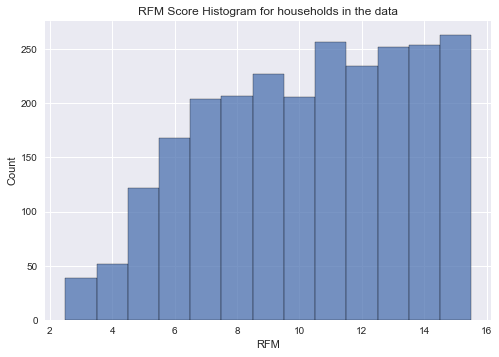

In [20]:
sns.histplot(df['RFM'], discrete=True)
plt.title('RFM Score Histogram for households in the data')
plt.show()

There is tons of discussion to be had about what RFM labels indicate to us about our sample population. Most likely we would want a uniform distribution of scores; but I've made some assumptions in order to classify this data as accurately as I can, instead of pushing the data into a normal or uniform distribution. This is introducing bias, in exchange for reducing the error in our data collection process (some very low-recency customers vs. many very-high-recency customers). 

### Plotting the Category Sales by Customer RFM Score Ranks

Now that we have defined the RFM score for each of our ~2500 households, let's take a cursory look at each group's sales participation over time...

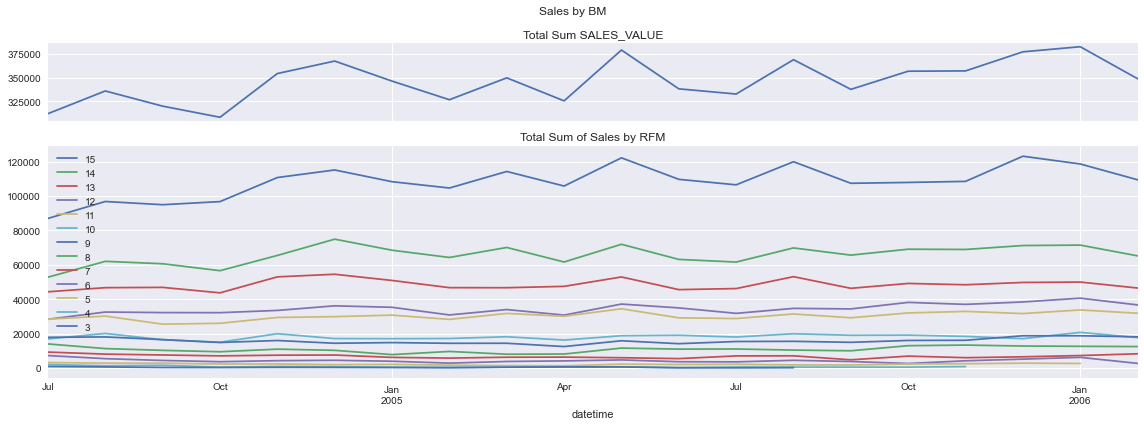

In [21]:
def compare_group_sales(merged, 
                        hh_agg, 
                        label_col='RFM',
                       date_col='datetime', 
                       resample_rule='BM',
                       sales_col='SALES_VALUE',
                      mean=True):
    
    """Using `household_key`,
        plot the sales for each unique label in `label_col` (from `hh_agg`), 

        using the `sales_col` `and date_col` found in `merged`

                                    """
    
    ## show the total sales at the top; adjust height ratios to emphasize the bottom plot
    plt.subplots(2,1,figsize=(16,6), sharex=True,gridspec_kw={'height_ratios': [1,3]})
    plt.suptitle(f'Sales by {resample_rule}')
    
    # total sales for all households in merged
    plt.subplots_adjust(hspace=0.1)
    plt.subplot(2,1,1)
    plt.title(f'Total Sum {sales_col}')
    merged.resample(resample_rule, on=date_col)[sales_col].sum().plot(label='Total')

    
    if mean == True:
    # divide the sales total over `resample_rule` by the number of households in each group, and plot.
        plt.subplot(2,1,2)
        plt.title(f'Mean Sum of Sales by {label_col}') 
        for rank in reversed(np.sort(hh_agg[label_col].unique())):
            lst = list(hh_agg[hh_agg[label_col]==rank].index)
            try:
                (merged[merged['household_key'].isin(lst)].resample(resample_rule, on=date_col)[sales_col].sum()/len(lst)).plot(label=f'{rank}')
            except:
                pass
            
    elif mean == False:
        plt.subplot(2,1,2)
        plt.title(f'Total Sum of Sales by {label_col}') 
        for rank in reversed(np.sort(hh_agg[label_col].unique())):
            lst = list(hh_agg[hh_agg[label_col]==rank].index)
            try:
                merged[merged['household_key'].isin(lst)].resample(resample_rule, on=date_col)[sales_col].sum().plot(label=f'{rank}')
            except:
                pass
        
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    
    
compare_group_sales(merged, df, mean=False)

As we might expect, our most valuable customers do quite well; at the highest sales peak there, customers with a perfect score of 15 are making up around 1/3 of our sales.

We see the echo of our sales spikes effectively 'filtered' down; our most valuable customers appear to be the ones who drive the spikes in our sales data. 

Focusing advertising on these customers makes sense; we might also consider that offering a 'lifestyle' of products similar to those purchased by our highest-grossing households might encourage other customers to purchase in a similar fashion.

If we parsed the scores down into 5 bins once again into a normal distribution:

RFM
3      924
2      579
4      506
5      263
1      213
dtype: int64


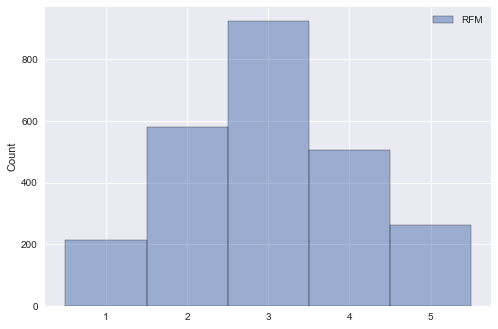

In [22]:
customer_ranks = pd.cut(df['RFM'], bins=[0,6,9,13,15,np.inf], labels=[1,2,3,4,5], right=False).astype(int)
customer_ranks = pd.DataFrame(customer_ranks) ## THIS IS HACKY BRO
sns.histplot(customer_ranks, discrete=True)

print(customer_ranks.value_counts())

And then compare their mean sales by score;

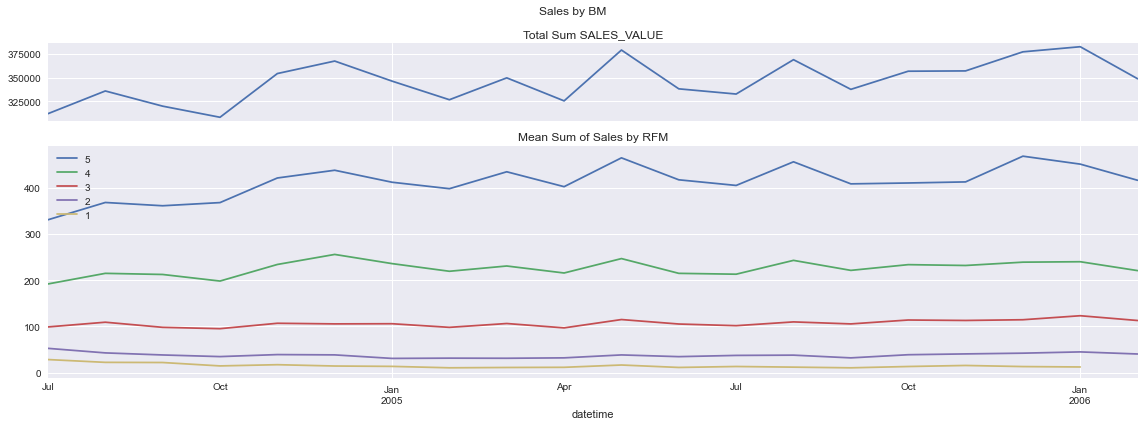

In [23]:
compare_group_sales(merged, customer_ranks,mean=True);

We see that our definition is maintained. However if we examine the total sales;

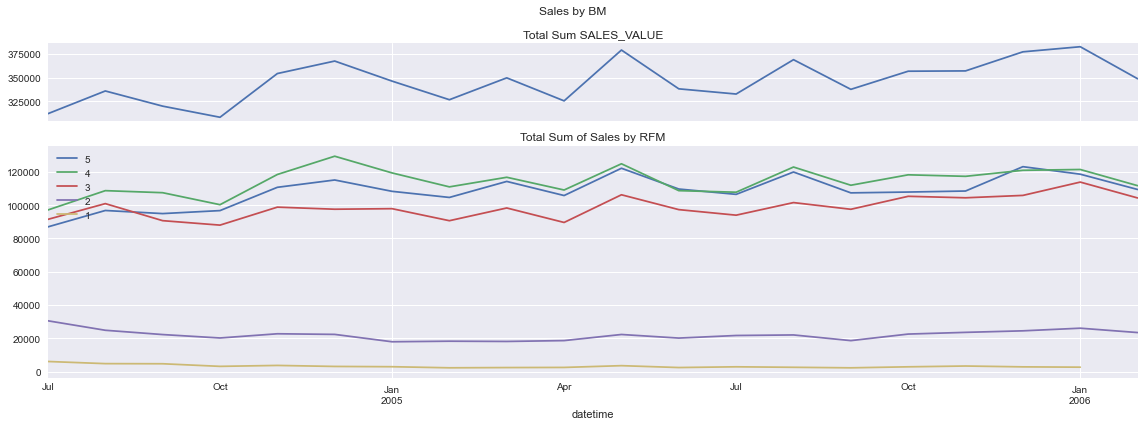

In [24]:
compare_group_sales(merged, customer_ranks,mean=False);

We can see that RFM bin 4 (score 13+14) has a nearly equivalent total sales value as RFM bin 5 (score 15). Bin 3 (score 10, 11, 12) has a similar total sales contribution as well. This is despite or because of significant class imbalances. I find this to be promising, as an effective way to group our customers; there is proportionality and distinction. 

I'm going to tag these labels on as well:

In [25]:
df['RFM Bins'] = customer_ranks

## RFM Function

And the function; we'll bring all of our profile-development functions into one dataframe at the bottom of the notebook.

In [26]:
def RFM_Score(merged):
    last_days = merged.groupby('household_key')['DAY'].max()
    R = pd.cut(last_days, [0, 525, 615, 675, 700, np.inf], labels=[1,2,3,4,5], ordered=True)
    num_baskets = merged.groupby('household_key')['BASKET_ID'].nunique()
    grouper = merged.groupby('household_key')['DAY']
    days_in_data = grouper.max() - grouper.min() + 1 #(no day 0 in our data)
    transactions_per_day = num_baskets/days_in_data
    F = pd.qcut(transactions_per_day, 5, labels=[1,2,3,4,5])
    M = pd.qcut(np.log(merged.groupby('household_key')['SALES_VALUE'].sum()), 5, labels=[1,2,3,4,5])
    df = pd.concat([R, F, M], axis=1)
    df.columns = ['R', 'F', 'M']
    df['RFM'] = df.sum(axis=1).astype(int)
    customer_ranks = pd.cut(df['RFM'], bins=[0,6,9,13,15, np.inf], labels=[1,2,3,4,5], right=False).astype(int)
    customer_ranks = pd.DataFrame(customer_ranks) ## THIS IS HACKY BRO
    df['RFM Bins'] = customer_ranks

    return df

all(df == RFM_Score(merged))

True

# Feature Engineering

To create some more definition for our customer profiles, I'd like to aggregate the transaction data we have for each household. While it might be interesting to compare households using deep learning (perhaps a tensor composed of sales by month for each category, for example), I am still learning.

I propose to add in the sales by category for each household. 

In [27]:
import warnings
warnings.filterwarnings('ignore')

## Section Sales

In [28]:
def get_section_sales(merged) -> pd.DataFrame():

    # get dummies for each transaction row
    section_dummies = pd.get_dummies(merged['Section Labels'])
    # multiply each row by it's SALES VALUE
    section_sales = section_dummies.apply(lambda x: x * merged['SALES_VALUE'])

#             # check
#     idx = merged.index
#     print(all(section_sales.index == idx))

    section_sales.join(merged[['household_key']]).groupby('household_key').agg(sum)

    # add and group by household key, sum all rows from the dummy columns. this one looks funny but I think it's right
    section_sales = section_sales.join(merged[['household_key']]).groupby('household_key').sum()



    return section_sales

section_sales = get_section_sales(merged)
section_sales

,alcohol,beverages,concessions,dairy,drug,garden,grain_goods,grocery,home_family,junk_food,kitchen,meat,misc,produce,seasonal
household_key,,,,,,,,,,,,,,,
1,6.48,314.83,20.33,362.76,53.44,0.00,668.41,230.24,537.29,764.02,1.59,379.04,303.82,477.82,0.00
2,47.67,91.59,41.93,157.36,45.10,0.00,144.89,47.21,477.92,255.63,7.98,277.78,139.88,212.41,6.99
3,5.72,95.38,43.88,126.85,5.37,0.00,272.97,136.42,161.92,508.39,0.00,814.45,198.42,261.44,1.99
4,248.72,2.99,4.89,132.36,8.08,0.00,93.72,85.07,148.71,261.64,0.00,135.09,60.13,18.71,0.00
5,51.75,57.25,2.49,53.18,46.42,0.00,17.42,15.96,162.64,34.12,3.99,154.29,81.88,12.64,1.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,166.03,85.29,22.28,242.55,1.85,0.00,321.16,103.29,424.82,360.46,7.48,1587.79,358.50,332.36,1.79
2497,371.42,123.06,79.81,468.03,61.09,9.28,570.01,350.91,868.09,832.75,3.99,1560.83,529.81,940.00,23.47
2498,137.29,138.24,54.13,391.57,156.36,5.17,319.38,145.57,262.77,252.69,0.00,305.32,128.00,228.36,0.00


Because these product labels are meaningful, we could directly bin households based on their total spend on some indicative categories:
    
- alcohol
- junk food
- meat
- home/family
- produce etc.



### Plotting Section Sales Distributions

This function allows us to pass a boolean argument to the `log` parameter.

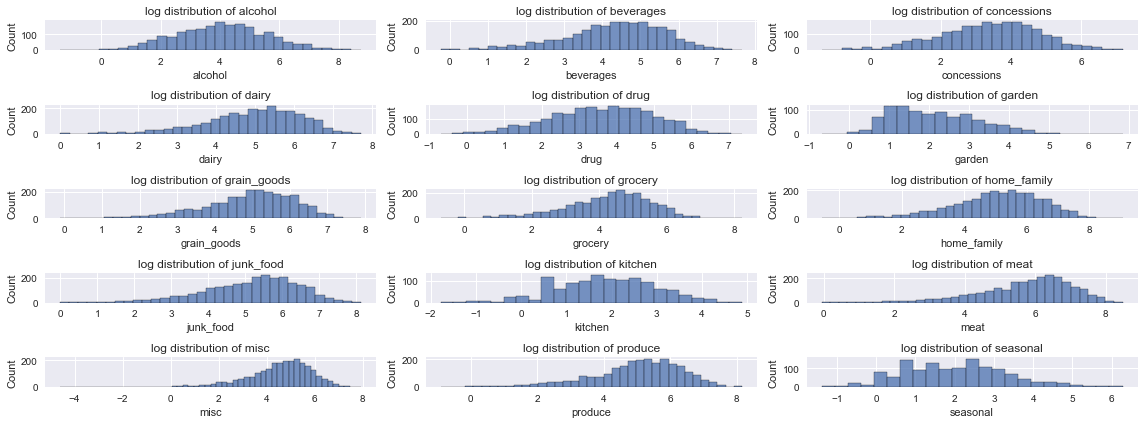

In [29]:
def plot_category_distributions(section_sales, log=False):
    """hardcoded to 15 section categories; accepts hh_agg[[section_sales_cols]]"""
    
    plt.subplots(5,3,figsize=(16,6)) 
    # iterate over columns in section_sales...
    for idx, col in enumerate(section_sales):
        plt.subplot(5,3,idx+1)
        
        
        # show the log distributions
        if log==True:
            plt.title(f'log distribution of {col}')
            sns.histplot(np.log(section_sales[col]), label=f'{col}')
            
        # else show the untransformed distributions
        else:
            plt.title(f'distribution of {col}')
            sns.histplot(section_sales[col], label=f'{col}')

    plt.tight_layout()
    plt.show()

plot_category_distributions(section_sales, log=True)

Once log-transformed, these distributions are fairly normal. I am shooting in the dark here, and would love the chance to learn from an experienced data scientist; my impression is that this engineered variance will allow our model to better distinguish the differences between households. 

## log transformed section sales, duration-based mean daily spend per category, mean basket spend


As additional engineered features, I'm going to add the log-transformed sum of total sales, as well as the mean daily purchase per section.

In [25]:
# log_transformed sum of section sales
log_transformed_section_sales = np.log(section_sales).replace([np.inf, -np.inf], np.nan).fillna(0)
log_transformed_section_sales.columns = [x + '_log_transformed_sales_total' for x in log_transformed_section_sales.columns]

In [26]:
# daily mean spend per section 
# based on # of days in data;
# add Days in Data for each household; similar to Frequency transformation
grouper = merged.groupby('household_key')['DAY']
duration = (grouper.max() - grouper.min()) + 1 # no day 0
duration.name = 'Days in Data'
# divide each column by the household's Days in Data value
test = section_sales.merge(duration, on='household_key').drop('Days in Data', axis=1)
daily_mean_spend_per_category = test.iloc[:,1:].div(duration, axis=0)
daily_mean_spend_per_category.columns = [x + '_daily_mean_spend_per_category' for x in daily_mean_spend_per_category.columns]

In [27]:
features = pd.concat([duration, 
                      log_transformed_section_sales, 
                      daily_mean_spend_per_category, 
                     ], axis=1)

In [28]:
features.head(1)

,Days in Data,alcohol_log_transformed_sales_total,beverages_log_transformed_sales_total,concessions_log_transformed_sales_total,dairy_log_transformed_sales_total,drug_log_transformed_sales_total,garden_log_transformed_sales_total,grain_goods_log_transformed_sales_total,grocery_log_transformed_sales_total,home_family_log_transformed_sales_total,...,garden_daily_mean_spend_per_category,grain_goods_daily_mean_spend_per_category,grocery_daily_mean_spend_per_category,home_family_daily_mean_spend_per_category,junk_food_daily_mean_spend_per_category,kitchen_daily_mean_spend_per_category,meat_daily_mean_spend_per_category,misc_daily_mean_spend_per_category,produce_daily_mean_spend_per_category,seasonal_daily_mean_spend_per_category
household_key,,,,,,,,,,,,,,,,,,,,,
1,606,1.868721,5.752033,3.012098,5.893741,3.97856,0.0,6.504902,5.439122,6.286538,...,0.0,1.102987,0.379934,0.886617,1.260759,0.002624,0.625479,0.501353,0.788482,0.0


In [29]:
df = df.merge(features, on='household_key')
df.head()

,R,F,M,RFM,RFM Bins,Days in Data,alcohol_log_transformed_sales_total,beverages_log_transformed_sales_total,concessions_log_transformed_sales_total,dairy_log_transformed_sales_total,...,garden_daily_mean_spend_per_category,grain_goods_daily_mean_spend_per_category,grocery_daily_mean_spend_per_category,home_family_daily_mean_spend_per_category,junk_food_daily_mean_spend_per_category,kitchen_daily_mean_spend_per_category,meat_daily_mean_spend_per_category,misc_daily_mean_spend_per_category,produce_daily_mean_spend_per_category,seasonal_daily_mean_spend_per_category
household_key,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,12,3,606,1.868721,5.752033,3.012098,5.893741,...,0.0,1.102987,0.379934,0.886617,1.260759,0.002624,0.625479,0.501353,0.788482,0.000000
2,3,2,3,8,2,566,3.864302,4.517322,3.736002,5.058536,...,0.0,0.255989,0.083410,0.844382,0.451643,0.014099,0.490777,0.247138,0.375283,0.012350
3,5,2,4,11,3,591,1.743969,4.557869,3.781459,4.843005,...,0.0,0.461878,0.230829,0.273976,0.860220,0.000000,1.378088,0.335736,0.442369,0.003367
4,3,2,2,7,2,524,5.516328,1.095273,1.587192,4.885525,...,0.0,0.178855,0.162347,0.283798,0.499313,0.000000,0.257805,0.114752,0.035706,0.000000
5,5,2,2,9,3,593,3.946424,4.047428,0.912283,3.973682,...,0.0,0.029376,0.026914,0.274266,0.057538,0.006728,0.260185,0.138078,0.021315,0.002175


Since we're including the mean and total spend per category in some form, I won't include the section sales proper.

# `make_hh_agg`

Now that we've generated some features about section spend, let's parse some more basic information about each household. 

In [30]:
def make_hh_agg(df) -> pd.DataFrame:


    # group transactions by household key and aggregate:
    hh_agg = df.groupby('household_key').agg(

    # total spend 
        total_spend=pd.NamedAgg(column="SALES_VALUE", aggfunc="sum"),
    # the total loyalty discount  
        total_loyalty=pd.NamedAgg(column="RETAIL_DISC", aggfunc="sum"), 
    # the total coupon match discount  
        total_coupon=pd.NamedAgg(column="COUPON_MATCH_DISC", aggfunc="sum"),
    # total quantity of items purchased   
        total_quantity=pd.NamedAgg(column='QUANTITY', aggfunc="sum"),

    # the number of baskets  
        num_baskets=pd.NamedAgg(column='BASKET_ID', aggfunc='nunique'),
    # number of unique of items purchased   
        unique_products=pd.NamedAgg(column='PRODUCT_ID', aggfunc='nunique'),

    # first day of purchase
        first_purchase=pd.NamedAgg(column='DAY', aggfunc='min'),
    # last day of purchase
        last_purchase=pd.NamedAgg(column='DAY', aggfunc='max'), 
                                                                )

    ### Deriving Avg. Basket Spend and Avg. Item Cost --

    # average basket spend
    hh_agg['avg_basket_spend'] = hh_agg['total_spend']/hh_agg['num_baskets']

    # average item cost (total spend/quantity)
    hh_agg['avg_item_cost'] = hh_agg['total_spend']/hh_agg['total_quantity']
    return hh_agg

make_hh_agg(merged).head(1)

,total_spend,total_loyalty,total_coupon,total_quantity,num_baskets,unique_products,first_purchase,last_purchase,avg_basket_spend,avg_item_cost
household_key,,,,,,,,,,
1,4120.07,-642.14,-25.65,1901,81,655,101,706,50.865062,2.167317


In [31]:
df = df.merge(make_hh_agg(merged), on='household_key')

df.head()

,R,F,M,RFM,RFM Bins,Days in Data,alcohol_log_transformed_sales_total,beverages_log_transformed_sales_total,concessions_log_transformed_sales_total,dairy_log_transformed_sales_total,...,total_spend,total_loyalty,total_coupon,total_quantity,num_baskets,unique_products,first_purchase,last_purchase,avg_basket_spend,avg_item_cost
household_key,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,12,3,606,1.868721,5.752033,3.012098,5.893741,...,4120.07,-642.14,-25.65,1901,81,655,101,706,50.865062,2.167317
2,3,2,3,8,2,566,3.864302,4.517322,3.736002,5.058536,...,1954.34,-333.50,0.00,833,45,545,103,668,43.429778,2.346146
3,5,2,4,11,3,591,1.743969,4.557869,3.781459,4.843005,...,2633.20,-667.59,-19.80,1589,46,513,113,703,57.243478,1.657143
4,3,2,2,7,2,524,5.516328,1.095273,1.587192,4.885525,...,1200.11,-115.65,0.00,382,30,164,104,627,40.003667,3.141649
5,5,2,2,9,3,593,3.946424,4.047428,0.912283,3.973682,...,695.32,-94.48,0.00,224,36,182,111,703,19.314444,3.104107


# `load_hh_agg`

Let's bring it all together.  Below is the function I've added to `dtcj` package.

In [32]:

def load_hh_agg(df) -> pd.DataFrame:
    '''accept the merged table or a subset thereof and return relevant house-level aggregations'''

    def make_hh_agg(df) -> pd.DataFrame:            
        # group transactions by household key and aggregate:
        hh_agg = df.groupby('household_key').agg(

        # total spend 
            total_spend=pd.NamedAgg(column="SALES_VALUE", aggfunc="sum"),
        # the total loyalty discount  
            total_loyalty=pd.NamedAgg(column="RETAIL_DISC", aggfunc="sum"), 
        # the total coupon match discount  
            total_coupon=pd.NamedAgg(column="COUPON_MATCH_DISC", aggfunc="sum"),
        # total quantity of items purchased   
            total_quantity=pd.NamedAgg(column='QUANTITY', aggfunc="sum"),

        # the number of baskets  
            num_baskets=pd.NamedAgg(column='BASKET_ID', aggfunc='nunique'),
        # number of unique of items purchased   
            unique_products=pd.NamedAgg(column='PRODUCT_ID', aggfunc='nunique'),

        # first day of purchase
            first_purchase=pd.NamedAgg(column='DAY', aggfunc='min'),
        # last day of purchase
            last_purchase=pd.NamedAgg(column='DAY', aggfunc='max'), 
                                                                    )

        ### Deriving Avg. Basket Spend and Avg. Item Cost --

        # average basket spend
        hh_agg['avg_basket_spend'] = hh_agg['total_spend']/hh_agg['num_baskets']

        # average item cost (total spend/quantity)
        hh_agg['avg_item_cost'] = hh_agg['total_spend']/hh_agg['total_quantity']
        return hh_agg


    def add_RFM(merged):
        last_days = merged.groupby('household_key')['DAY'].max()
        R = pd.cut(last_days, [0, 525, 615, 675, 700, np.inf], labels=[1,2,3,4,5], ordered=True)
        num_baskets = merged.groupby('household_key')['BASKET_ID'].nunique()
        grouper = merged.groupby('household_key')['DAY']
        days_in_data = grouper.max() - grouper.min() + 1 #(no day 0 in our data)
        transactions_per_day = num_baskets/days_in_data
        F = pd.qcut(transactions_per_day, 5, labels=[1,2,3,4,5])
        M = pd.qcut(np.log(merged.groupby('household_key')['SALES_VALUE'].sum()), 5, labels=[1,2,3,4,5])
        df = pd.concat([R, F, M], axis=1)
        df.columns = ['R', 'F', 'M']
        df['RFM'] = df.sum(axis=1).astype(int)
        customer_ranks = pd.cut(df['RFM'], bins=[0,6,9,13,15, np.inf], labels=[1,2,3,4,5], right=False).astype(int)
        customer_ranks = pd.DataFrame(customer_ranks) ## THIS IS HACKY BRO
        df['RFM Bins'] = customer_ranks

        return df
    
   
    def transformed_section_sales(merged):
        
        def get_section_sales(df) -> pd.DataFrame():

            idx = df.index
            # get dummies for each transaction row
            section_dummies = pd.get_dummies(df['Section Labels'])

            # multiply each row by it's SALES VALUE
            section_sales = section_dummies.apply(lambda x: x * df['SALES_VALUE'])
        #     print(all(section_sales.index == idx))
            # add and group by household key, sum all rows from the dummy columns
            section_sales = section_sales.join(df[['household_key']]).groupby('household_key').agg(sum)
            return section_sales
        
        # create section sales
        section_sales = get_section_sales(merged)
        
       # log_transformed sum of section sales
        log_transformed_section_sales = np.log(section_sales).replace([np.inf, -np.inf], np.nan).fillna(0)
        log_transformed_section_sales.columns = [x + '_log_transformed_sales_total' for x in log_transformed_section_sales.columns]

        # daily mean spend per section 
        # based on # of days in data;
        # add Days in Data for each household; similar to Frequency transformation
        grouper = merged.groupby('household_key')['DAY']
        duration = (grouper.max() - grouper.min()) + 1 # no day 0
        duration.name = 'Days in Data'
        # divide each column by the household's Days in Data value
        test = section_sales.merge(duration, on='household_key').drop('Days in Data', axis=1)
        daily_mean_spend_per_category = test.div(duration, axis=0)
        daily_mean_spend_per_category.columns = [x + '_daily_mean_spend_per_category' for x in daily_mean_spend_per_category.columns]
        return pd.concat([log_transformed_section_sales, daily_mean_spend_per_category], axis=1)
      
    
    ### RUNTIME
    
    hh_agg = pd.concat([make_hh_agg(df), transformed_section_sales(df), add_RFM(df)], axis=1)

    return hh_agg


In [35]:
hh_agg = load_hh_agg(merged)
hh_agg.shape, df.shape

((2485, 45), (2485, 45))